In [7]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download
from transformers import AutoformerForPrediction

sns.set_style('darkgrid')

In [8]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from huggingface_hub import hf_hub_download
from transformers import AutoformerForPrediction

sns.set_style('darkgrid')

In [9]:
#Download and load the dataset
file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

In [10]:
for key, value in batch.items():
    print(key, value.shape)

static_categorical_features torch.Size([64, 1])
static_real_features torch.Size([64, 1])
past_time_features torch.Size([64, 61, 2])
past_values torch.Size([64, 61])
past_observed_mask torch.Size([64, 61])
future_time_features torch.Size([64, 24, 2])
future_values torch.Size([64, 24])
future_observed_mask torch.Size([64, 24])


In [ ]:
# Load the pre-trained Autoformer model
model = AutoformerForPrediction.from_pretrained("huggingface/autoformer-tourism-monthly")

# During training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# During inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

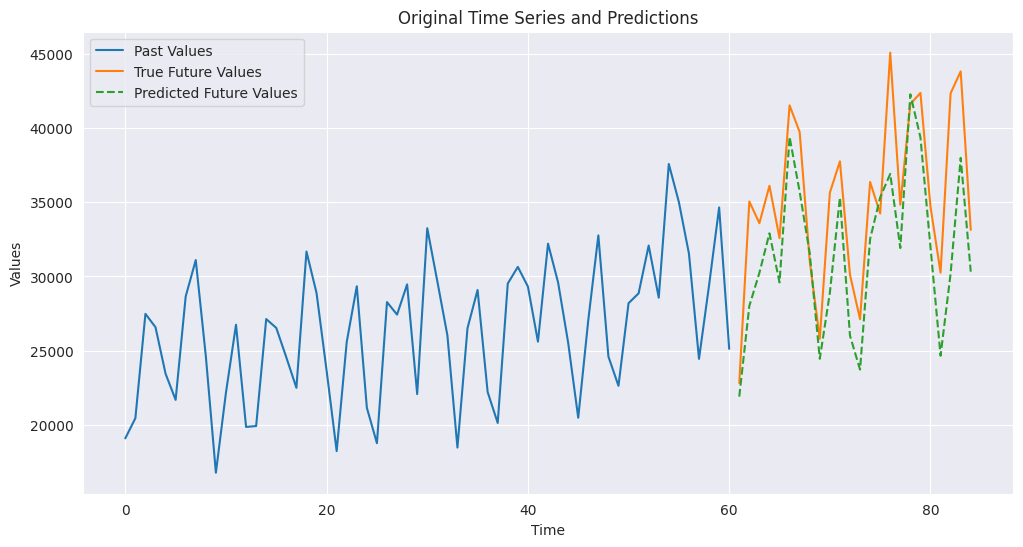

In [6]:
# Plotting
past_values = batch["past_values"].squeeze().numpy()
future_values = batch["future_values"].squeeze().numpy()
predicted_values = mean_prediction.squeeze().detach().numpy()

# Single sample for simplicity
past_values = past_values[0]
future_values = future_values[0]
predicted_values = predicted_values[0]

plt.figure(figsize=(12, 6))
plt.plot(range(len(past_values)), past_values, label='Past Values')
plt.plot(range(len(past_values), len(past_values) + len(future_values)), future_values, label='True Future Values')
plt.plot(range(len(past_values), len(past_values) + len(predicted_values)), predicted_values, label='Predicted Future Values', linestyle='dashed')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Original Time Series and Predictions')
plt.show()

Autoformer

In [71]:
from transformers import AutoformerConfig, AutoformerModel
import pandas as pd
import numpy as np

In [72]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [73]:
df.head()

,requests,memory,cpu
timestamp,,,
2023-10-01 00:00:00,6.0,0.105,0.003
2023-10-01 00:01:00,29.0,0.104,0.004
2023-10-01 00:02:00,12.0,0.105,0.003
2023-10-01 00:03:00,18.0,0.105,0.004
2023-10-01 00:04:00,4.0,0.105,0.003


In [74]:
past_values = torch.tensor(df['requests'].values, dtype=torch.float).unsqueeze(0)
past_time_features = torch.tensor(df[['memory', 'cpu']].values, dtype=torch.float).unsqueeze(0)
past_observed_mask = torch.tensor(~df['requests'].isna().values, dtype=torch.float).unsqueeze(0)


In [65]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TimeSeriesWindowDataset(Dataset):
    def __init__(self, df, context_length, prediction_length):
        self.context_length = context_length
        self.prediction_length = prediction_length

        self.values = df['requests'].values
        self.features = df[['memory', 'cpu']].values

        self.length = len(df) - context_length - prediction_length + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Context (past)
        past_values = self.values[idx:idx + self.context_length]
        past_time_features = self.features[idx:idx + self.context_length]

        # Prediction target / future values
        future_values = self.values[
            idx + self.context_length : idx + self.context_length + self.prediction_length
        ]

        future_time_features = self.features[
            idx + self.context_length : idx + self.context_length + self.prediction_length
        ]

        # Observed mask
        past_observed_mask = ~np.isnan(past_values)

        return {
            'past_values': torch.tensor(past_values, dtype=torch.float),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.float),
            'target': torch.tensor(future_values, dtype=torch.float),
            'future_values': torch.tensor(future_values, dtype=torch.float),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float)
        }


In [66]:
# Assuming df is already loaded and timestamp is index
dataset = TimeSeriesWindowDataset(df, context_length=60, prediction_length=10)


In [67]:
# Access first sample
sample = dataset[0]
print(sample['past_values'].shape)        # torch.Size([60])
print(sample['past_time_features'].shape)  # torch.Size([60, 2])
print(sample['target'].shape)             # torch.Size([10])

torch.Size([60])
torch.Size([60, 2])
torch.Size([10])


In [68]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)
for batch in loader:
    print(batch['past_values'].shape)  # → torch.Size([32, 60])
    print(batch['past_time_features'].shape)  # → torch.Size([32, 60, 2])
    print(batch['target'].shape)
    print(batch['future_values'].shape)  # → torch.Size([32, 10])
    break

torch.Size([32, 60])
torch.Size([32, 60, 2])
torch.Size([32, 10])
torch.Size([32, 10])


MODEL CONFIGURATION

In [69]:
configuration = AutoformerConfig(prediction_length=10, context_length=60, lags_sequence=[1, 2])
model = AutoformerModel(configuration)


In [70]:

for batch in loader:
    output = model.forward(
        past_values=batch['past_values'],
        past_time_features=batch['past_time_features'],
        past_observed_mask=batch['past_observed_mask'],
        future_values=batch['future_values'],
        future_time_features=batch['future_time_features']
    )

ValueError: lags cannot go further than history length, found lag 2 while history length is only 70